Original dataset shape: (5000000, 19)
Original dataset class counts:
class_label
0.0    2712173
1.0    2287827
Name: count, dtype: int64
Sampling fraction: 0.2
Sampled dataset shape: (1000000, 19)
Sampled dataset class counts:
class_label
0.0    542435
1.0    457565
Name: count, dtype: int64
[2025-03-18 07:33:47.196] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/home/di/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


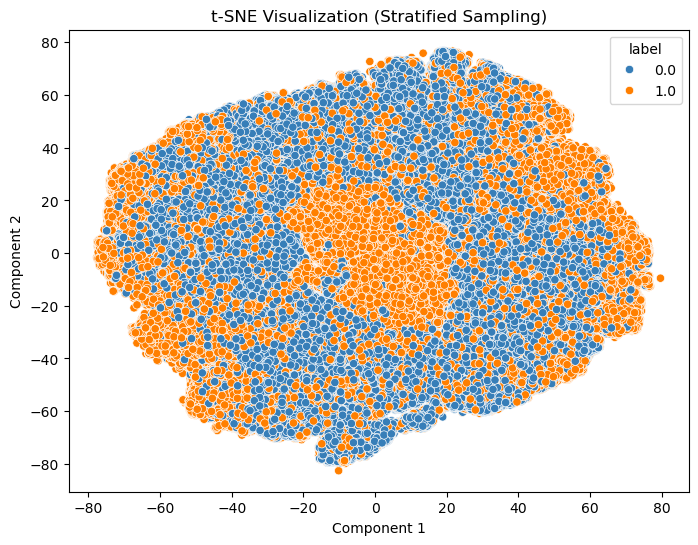

CPU times: user 2min 26s, sys: 3.71 s, total: 2min 30s
Wall time: 2min 33s


In [1]:
%%time
import cudf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.manifold import TSNE

# Load the original dataset
higgs = cudf.read_csv("SUSY_HEADER.csv")
print("Original dataset shape:", higgs.shape)
print("Original dataset class counts:")
print(higgs['class_label'].value_counts())

# Determine the overall sampling fraction to reach ~1,000,000 instances
target_total = 1000000
frac = target_total / len(higgs)
print("Sampling fraction:", frac)

# Perform stratified sampling for each class:
sampled_class_0 = higgs[higgs['class_label'] == 0].sample(frac=frac, random_state=42)
sampled_class_1 = higgs[higgs['class_label'] == 1].sample(frac=frac, random_state=42)

# Combine the sampled data and shuffle it
higgs_sampled = cudf.concat([sampled_class_0, sampled_class_1]).sample(frac=1, random_state=42)
print("Sampled dataset shape:", higgs_sampled.shape)
print("Sampled dataset class counts:")
print(higgs_sampled['class_label'].value_counts())

# Separate features and label
features = higgs_sampled.drop(columns=['class_label'])
labels = higgs_sampled['class_label']

# Create a TSNE instance
tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate=200.0,
    n_iter=1000)

# Fit and transform the feature data to get the 2D embedding.
embedding = tsne.fit_transform(features)

# Convert the embedding to a NumPy array (if needed)
if hasattr(embedding, "get"):
    embedding = embedding.get()
elif hasattr(embedding, "to_numpy"):
    embedding = embedding.to_numpy()

# Create a pandas DataFrame for plotting
embedding_df = pd.DataFrame(embedding, columns=['Component1', 'Component2'])
embedding_df['label'] = labels.to_pandas().values  # Convert cuDF Series to pandas Series

# Define the color palette for the two classes
palette = ['#377eb8', '#ff7f00']

# Plot the t-SNE embedding with colors representing the classes.
plt.figure(figsize=(8, 6))
sns.scatterplot(data=embedding_df, x='Component1', y='Component2', hue='label', palette=palette)
plt.title('t-SNE Visualization (Stratified Sampling)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
